## Case Study 1: Canonical fMRI Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### Overview
In canonical fMRI analysis, we have:

$$ Y = XW + \epsilon $$

We will assume that the weights are matrix-normal distributed such that:

$$ W \sim \mathcal{MN}(M_{k,v}, \Sigma_{Wk}, \Sigma_{Wv}) $$

$$ W \sim \mathcal{MN}(0, \Sigma_{Wk}, \Sigma_{Wv}) $$

As a reminder:

$$ Y \sim \mathcal{MN}(XW, \Sigma_t, \Sigma_v) $$

$$ \text{vec}(Y) \sim \mathcal{N} \left( \text{vec}(XW), \Sigma_v \otimes \Sigma_t \right) $$

When $W$ is mean-centered at 0 as above, we can marginalize such that:

$$ \text{vec}(Y) \sim \mathcal{N}(0, \Sigma_{v} \otimes \Sigma_{t} + X \left( \Sigma_{Wv} \otimes \Sigma_{Wk} \right) X^T )$$

This general formula is the heart of the software.

### Section 1: Simulate Data 

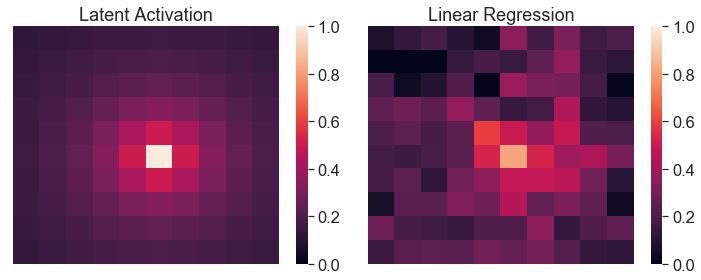

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
nX = nY = 10
V = nX * nY
T = 100

## Define noise.
noise = 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define voxel coordinates.
rr = np.array(np.meshgrid(np.arange(nX), np.arange(nY))).reshape(2,-1).T

## Define latent weights.
W = 1 / (1 + np.linalg.norm(rr - np.array([nX/2,nY/2]), axis=-1))

## Define design matrix.
X = np.linspace(-1,1,T).reshape(-1,1)

## Define observed data.
Y = np.outer(X,W)
Y += np.random.normal(0, noise, size=Y.shape)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot latent activation.
sns.heatmap(W.reshape(nX,nY), vmin=0, vmax=1, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Latent Activation')

## Plot latent activation.
W_hat, _, _, _ = np.linalg.lstsq(X, Y)
sns.heatmap(W_hat.reshape(nX,nY), vmin=0, vmax=1, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Linear Regression')

plt.tight_layout()

### Section 2: Isotropic Covariance 

Success = True


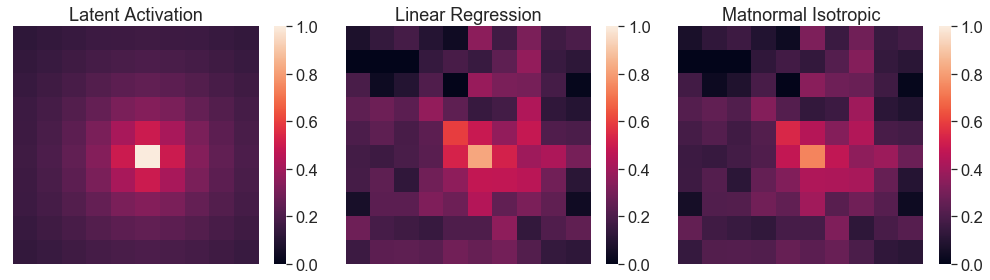

In [3]:
from matnormal import CovIdentity, CovIsotropic, matnormal_regression

## Initialize covariances.
Omega_v = CovIsotropic(V)
Omega_k = CovIdentity(1)
Sigma_t = CovIsotropic(T)
Sigma_v = CovIdentity(V)

## Fit model.
fit = matnormal_regression(Y, X, Omega_k, Omega_v, Sigma_t, Sigma_v)
print('Success = %s' %fit.success)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(14,4))

## Plot latent activation.
sns.heatmap(W.reshape(nX,nY), vmin=0, vmax=1, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Latent Activation')

## Plot latent activation.
sns.heatmap(W_hat.reshape(nX,nY), vmin=0, vmax=1, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Linear Regression')

sns.heatmap(fit.W.reshape(nX,nY), vmin=0, vmax=1, ax=axes[2])
axes[2].set(xticks=[], yticks=[], title='Matnormal Isotropic')

plt.tight_layout()

### Section 3: Graph Laplacian

Some notation:

$$ \Sigma_{Wv} = C = \tau(D - A)^{-1} $$

$$ \Sigma_{Wk} = I_k $$

$$ \Sigma_{v} \otimes \Sigma_{t} = \Sigma $$

Then we have, substituting $ C = C \otimes I_k $: 

$$ \text{vec}(Y) \sim \mathcal{N}(0, \Sigma + X C X^T )$$

With the Woodbury identity (matrix inversion lemma):

$$ \Sigma + X C X^T = \Sigma^{-1} - \Sigma^{-1} X \left( C^{-1} + X^T \Sigma^{-1} X \right)^{-1} X^T \Sigma^{-1} $$

Why does this matter? Well $\Sigma$ is likely sparse, as is $C^{-1}$. Thus very efficient to compute. 

Success = True


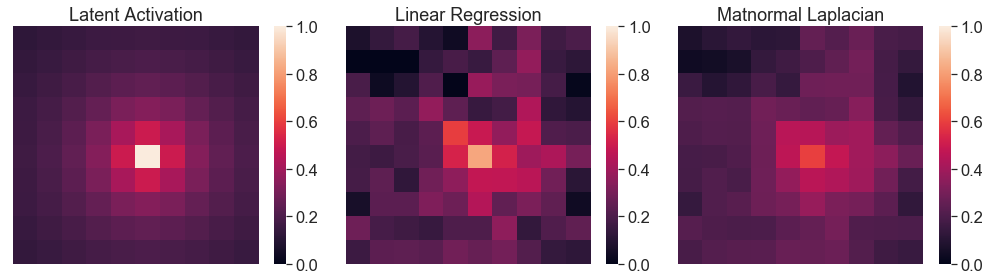

In [4]:
from matnormal import CovGraphLaplacian, vol_to_adj

## Define adjacency matrix.
A = vol_to_adj(rr)

## Initialize covariances.
Omega_k = CovIdentity(1)
Omega_v = CovGraphLaplacian(A)
Sigma_t = CovIsotropic(T)
Sigma_v = CovIdentity(V)

## Fit model.
fit = matnormal_regression(Y, X, Omega_k, Omega_v, Sigma_t, Sigma_v)
print('Success = %s' %fit.success)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(14,4))

## Plot latent activation.
sns.heatmap(W.reshape(nX,nY), vmin=0, vmax=1, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Latent Activation')

## Plot latent activation.
sns.heatmap(W_hat.reshape(nX,nY), vmin=0, vmax=1, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Linear Regression')

sns.heatmap(fit.W.reshape(nX,nY), vmin=0, vmax=1, ax=axes[2])
axes[2].set(xticks=[], yticks=[], title='Matnormal Laplacian')

plt.tight_layout()